# Linear Regression

In [1]:
# Package Setup
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import datetime as datetime

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# User: set up some general stuff
path = 'https://raw.githubusercontent.com/negarfazeli/energy-prediction/master/'

train_start_date = '2001-01-01'
train_end_date = '2013-12-01'
test_start_date = '2014-01-01'
test_end_date = '2017-07-01'

# If setting feature names manually:
# feature_names = ['Total.Biomass.Consump.TrillBTU.',
#  'BioMass.Prod.Trill.BTU.',
#  'Natural.Gas.Consumed.by.the.Transportation.Sector..Vehicle.Fuel..Billion.Cubic.Feet.',
#  'GeoConsump.TrillBtu.',
#  'GenCalifornia...other.thousand.megawatthours',
#  'Total.Renewable.Consump.TrillBTU.',
#  'Total.RenProd..TrillBtu.',
#  'WasteConsump.TrillBTU.',
#  'Electricity.Direct.Use..Billion.Kilowatthours.',
#  'Av.Temp']

In [3]:
# If setting feature names automatically from predicted features matrix:
X_pred = pd.read_csv('https://raw.githubusercontent.com/negarfazeli/energy-prediction/master/predicted-features_new_vif_pearson.csv')
feature_names = list(X_pred.columns)[1:-2]

## Prepare Data

In [4]:
# Load Data
df = pd.read_csv(path+'final.csv')

In [5]:
df.head()

,Month,GenCalifornia...all.fuels..utility.scale..thousand.megawatthours,GenCalifornia...coal.thousand.megawatthours,GenCalifornia...petroleum.liquids.thousand.megawatthours,GenCalifornia...petroleum.coke.thousand.megawatthours,GenCalifornia...natural.gas.thousand.megawatthours,GenCalifornia...other.gases.thousand.megawatthours,GenCalifornia...nuclear.thousand.megawatthours,GenCalifornia...conventional.hydroelectric.thousand.megawatthours,GenCalifornia...other.renewables.thousand.megawatthours,...,Natural.Gas.Consumed.by.the.Transportation.Sector..Pipelines.and.Distribution..Billion.Cubic.Feet.,Natural.Gas.Consumed.by.the.Transportation.Sector..Vehicle.Fuel..Billion.Cubic.Feet.,Natural.Gas.Consumed.by.the.Transportation.Sector..Total..Billion.Cubic.Feet.,Natural.Gas.Consumed.by.the.Electric.Power.Sector..Billion.Cubic.Feet.,Natural.Gas.Consumption..Total..Billion.Cubic.Feet.,Average.retail.price.of.electricity.monthly.California...all.sectors.cents.per.kilowatthour,Consumption.for.electricity.generation.for.all.sectors.monthly.California...coal.thousand.tons,Consumption.for.electricity.generation.for.natural.gas.monthly.California...all.sectors.thousand.Mcf,Retail.sales.of.electricity.monthly.California...all.sectors.million.kilowatthours,Total.consumption.for.all.sectors.monthly.California...coal.thousand.tons
0,Jul-17,20980.32206,23.12607,3.44655,0.0,9653.23988,111.09914,1648.012,4371.98080,5008.53970,...,53.572,3.694,57.266,1051.503,2111.264,17.53,5.424,70676.525,24342.39981,48.016
1,Jun-17,18260.48619,26.82868,3.31392,0.0,7191.91812,118.54188,959.831,4455.83824,5388.18090,...,47.968,3.560,51.529,834.144,1890.416,17.55,6.162,52936.269,22235.30692,55.518
2,May-17,16878.55820,14.41477,3.32468,0.0,5243.68841,136.91117,840.135,4972.12223,5532.79051,...,47.874,3.679,51.553,697.129,1886.702,15.46,3.572,38705.087,19838.08134,39.540
3,Apr-17,15436.06640,19.33808,3.53045,0.0,4248.56449,129.62659,1412.868,4397.51087,5155.78836,...,48.577,3.560,52.137,613.895,1914.399,13.12,4.529,30739.269,17875.54180,43.499
4,Mar-17,16101.84657,27.06185,6.00000,0.0,4816.73759,118.23473,1569.141,4481.18059,5062.00859,...,63.788,3.679,67.466,667.123,2513.842,15.39,6.222,36072.471,19947.97958,55.854


In [6]:
# Format Month Column and Set as Index

# utility function: a function to modify the format of the date 
def modify_data(s):
    if len(s)==6:
        s = s[:4]+'20'+s[4:]
    else:
        s = s[:4]+'200'+s[4:]
    return(s)

# Modify the format of the date
df['Month'] = df['Month'].apply(modify_data)
# Convert 'Month' to datetime format
df['Month'] = pd.to_datetime(df['Month'])
# Set 'Month' as index
df.index = df.Month
# Drop 'Month' column
df = df.drop('Month', axis=1)

In [7]:
# Sort by Month
df.sort_index(ascending=True, inplace=True)

In [8]:
print('Outcome Variable: Average.Retail.Price.of.Electricity..Residential..Cents.per.Kilowatthour...Including.Taxes.')

Outcome Variable: Average.Retail.Price.of.Electricity..Residential..Cents.per.Kilowatthour...Including.Taxes.


In [9]:
# Split into X and y
X = df.drop("Average.Retail.Price.of.Electricity..Residential..Cents.per.Kilowatthour...Including.Taxes.", axis=1) # Input Variables
y = df["Average.Retail.Price.of.Electricity..Residential..Cents.per.Kilowatthour...Including.Taxes."]              # Outcome Variable

In [10]:
# Drop Features we aren't using
X = X[feature_names]

In [11]:
# Split into train and test
X_train = X[train_start_date:train_end_date]
X_test = X[test_start_date:test_end_date]

y_train = y[train_start_date:train_end_date]
y_test = y[test_start_date:test_end_date]

## Visualize Data to check for linear relationships

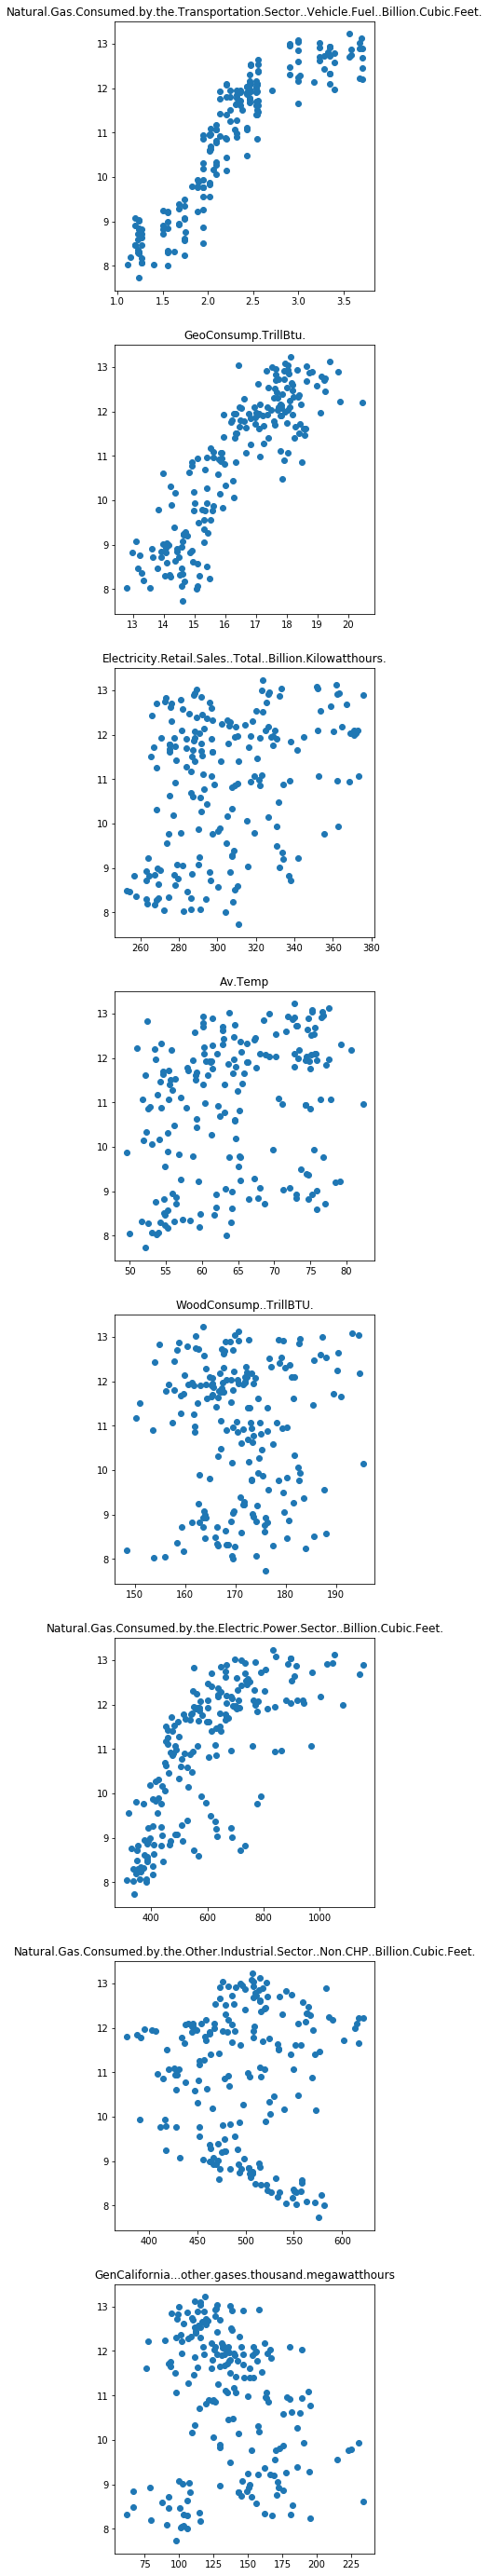

In [12]:
# Plot Features vs. Data to understand if there are linear relationships
# Dimensions os subplot need fixed - for now, use individual plots

plt.figure(figsize = (5,50))

# Create list of subplot names
subplotnames = []
for i in range(len(feature_names)):
    subplotnames += ['subplot' + str(i)]                 # put name of subplot in list, e.g. 'subplot0'
    subplotnames[i] = plt.subplot(len(feature_names), 1, i+1) # initialize subplot, e.g. subplot0 = plt.subplot(22, 1, 1)

# Scatter plot for each feature
for i in range(len(feature_names)):
    x_pts = X.iloc[:,i]
    y_pts = y
    subplotnames[i].scatter(x_pts, y)
    subplotnames[i].set_title(X.columns.values[i]);

## Train Linear Regression Model

In [13]:
# Import packages
from sklearn.linear_model import LinearRegression

In [14]:
# utility function
def combinations(iterable, r):
    # combinations('ABCD', 2) --> AB AC AD BC BD CD
    # combinations(range(4), 3) --> 012 013 023 123
    pool = list(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield list(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield list(pool[i] for i in indices)

In [15]:
# Create a list of all possible combinations of 0-11 of the 11 columns
column_combos = []

for i in range(X.shape[1]):
    column_combos += list(combinations(range(X.shape[1]), i+1))

In [16]:
# Create empty dataframe to store results from each regression
results = pd.DataFrame(columns=['Column Indices from Feature Matrix', 'Intercept', 'Coefficients', 'R-Squared'])

In [17]:
# for each item in column_combos
for i in range(len(column_combos)):
    # Get feature name strings for column_combos numbers
    temp_feature_names = []
    for j in range(len(column_combos[i])): # for however many columns the column combo item indicates
        temp_feature_names += [list(X)[column_combos[i][j]]]
    # create X_temp matrix, using the columns indicated by column_combos
    X_temp = X[temp_feature_names]
    # split into train and test data
    X_train = X_temp[train_start_date:train_end_date]
    X_test = X_temp[test_start_date:test_end_date]
    # run regression
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    # store: column indices, intercept, coefficients, R-squared value
    new_row = pd.DataFrame(data={'Column Indices from Feature Matrix': [column_combos[i]],
                                 'Intercept': [linreg.intercept_],
                                 'Coefficients': [linreg.coef_],
                                 'R-Squared': [linreg.score(X_test, y_test)]})
    results = results.append(new_row, ignore_index=True)

In [18]:
results.tail()

,Coefficients,Column Indices from Feature Matrix,Intercept,R-Squared
250,"[2.6612517677937744, -0.017430356530838395, -0...","[0, 1, 2, 4, 5, 6, 7]",10.977944,-18.788112
251,"[2.937953336567582, -0.04490404108362133, 0.01...","[0, 1, 3, 4, 5, 6, 7]",9.314286,-22.013244
252,"[2.730629509086624, -0.005635829220035037, 0.0...","[0, 2, 3, 4, 5, 6, 7]",9.608507,-20.547004
253,"[0.7006456312531949, -0.010443515940022605, -0...","[1, 2, 3, 4, 5, 6, 7]",8.039825,-4.604267
254,"[2.83350025885712, -0.034298552367348197, -0.0...","[0, 1, 2, 3, 4, 5, 6, 7]",9.800537,-22.376336


In [19]:
# Select best model from results
# find index for highest R-Squared
best_result_row = results['R-Squared'].idxmax(axis=1)
# select 'Column Indices from Feature Matrix' from row with highest R-Squared
best_column_combo = results.iloc[best_result_row,1]
# using 'Coefficients', select column names from feature_names
best_column_names = []
for i in range(len(best_column_combo)):
    best_column_names += [feature_names[best_column_combo[i]]]
# Split train and test features
X_best = X[best_column_names]
X_train = X_best[train_start_date:train_end_date]
X_test = X_best[test_start_date:test_end_date]
# Train model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [20]:
print('Best Linear Predictors: \n', best_column_names)
print('R-Squared: \n', results.iloc[best_result_row,3])
print('Coefficients: \n', results.iloc[best_result_row,0])
print('Intercept: \n', results.iloc[best_result_row,2])

Best Linear Predictors: 
 ['GeoConsump.TrillBtu.', 'Electricity.Retail.Sales..Total..Billion.Kilowatthours.', 'Av.Temp', 'Natural.Gas.Consumed.by.the.Electric.Power.Sector..Billion.Cubic.Feet.']
R-Squared: 
 -2.4792939315986615
Coefficients: 
 [ 0.66537636 -0.01503451  0.02187175  0.00367333]
Intercept: 
 0.9660214360452297


## 2014-2017: Predict Prices and Compare

In [21]:
# Load X predictions from 2014-2017
X_pred = pd.read_csv('https://raw.githubusercontent.com/negarfazeli/energy-prediction/master/predicted-features_new_vif_pearson.csv')

In [22]:
# Resort X_pred by month
X_pred.sort_index(ascending=False, inplace=True)

In [23]:
# Set index for X_pred to be the same as for X_test
X_pred.index = X_test.index

In [24]:
# Extract the best features from the predicted features matrix
X_pred_best = X_pred[test_start_date:test_end_date] # Get just the dates aligning with test data
X_pred_best = X_pred_best[best_column_names] # Extract the best columns

In [25]:
# Model Prediction of Y using Predicted Xs
y_train_pred = pd.Series(linreg.predict(X_train))
y_test_pred = pd.Series(linreg.predict(X_test))
y_pred_pred = pd.Series(linreg.predict(X_pred_best))

In [26]:
# Model Accuracy
from sklearn.metrics import mean_squared_error
print("MSE, Training Data: %.2f"
      % mean_squared_error(y_train, y_train_pred))
print("MSE, Test Data: %.2f"
      % mean_squared_error(y_test, y_test_pred))
print("MSE, Predicted Feature Data: %.2f"
      % mean_squared_error(y_test, y_pred_pred))

MSE, Training Data: 0.39
MSE, Test Data: 0.47
MSE, Predicted Feature Data: 2.34


In [27]:
# Set index for y_pred_pred as datetime for graphing
y_pred_pred.index = y_test.index

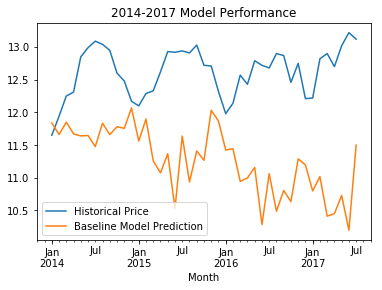

In [28]:
# Plot 2014-2017 Actual vs. Predicted
from matplotlib import pyplot
pyplot.title('2014-2017 Model Performance')
ax = y_test.plot(label='Historical Price')
ax = y_pred_pred.plot(label='Baseline Model Prediction')
pyplot.legend()